<a href="https://colab.research.google.com/github/furio1999/Natural-Language-Processing/blob/main/Performing_Word_Embeddings_with_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Copyright 2021 Sapienza NLP research group (http://nlp.uniroma1.it/)**

Authors: Edoardo Barba, Michele Bevilacqua, Cesare Campagnano, Simone Conia, ‪Pere-Lluís Huguet Cabot‬, Luigi Procopio, Roberto Navigli

All the material is made available under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 License (international): https://creativecommons.org/licenses/by-nc-sa/4.0/.

# Word embeddings and Word2Vec
Word2Vec is a group of related methods to learn word embeddings using shallow neural networks. Given a large corpus of text, these techniques allow to learn a representation for each word such that words that share common contexts in the corpus are located close to each other in the vector space.
### Skip-Gram Model
It is one of the two word2vec methods to build word embeddings. We want words that appear in the same context to have similar representations, so we will use as training instance a given word and as its label a word that appears in the same context.

The model has the following architecture:

![Model architecture](https://miro.medium.com/max/3138/0*FTfdlZ7yDBoQ8c9W.png)

The weights of the dense layers will be updated during training, and we will use the weights of the first layer as word embeddings.


# Setup

In [ ]:
!pip install wget # to download data

In [ ]:
from sklearn.decomposition import PCA
from torch import FloatTensor as FT
from torch import LongTensor as LT
import matplotlib.pyplot as plt
import torch.nn as nn
import collections
import numpy as np
import torch
import wget
import json
import os
import re

# for cute iteration bars (during training etc.)
from tqdm.auto import tqdm

torch.manual_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root_folder = '/content/drive/My Drive/nlp_data/' # to save checkpoints

# Data Preparation

## Define the dataset
We define a class to handle the data. We can inherit the ```torch.utils.data.IterableDataset``` abstract class and override the ```__iter___``` method.

In [ ]:
class Word2VecDataset(torch.utils.data.IterableDataset):

    def __init__(self, txt_path, vocab_size, unk_token, window_size):
        """
        Args:
          txt_file (str): Path to the raw-text file.
          vocab_size (int): Maximum amount of words that we want to embed.
          unk_token (str): How will unknown words represented (e.g. 'UNK').
          window_size (int): Number of words to consider as context.
        """
        self.window_size = window_size
        # [[w1,s1, w2,s1, ..., w|s1|,s1], [w1,s2, w2,s2, ..., w|s2|,s2], ..., [w1,sn, ..., w|sn|,sn]]
        self.data_words = self.read_data(txt_path)
        self.build_vocabulary(vocab_size, unk_token)

    def __iter__(self):
        sentences = self.data_words
        for sentence in sentences:
            len_sentence = len(sentence)

            for input_idx in range(len_sentence):
                current_word = sentence[input_idx]
                # must be a word in the vocabulary
                if current_word in self.word2id and self.keep_word(current_word):
                    # left and right window indices
                    min_idx = max(0, input_idx - self.window_size)
                    max_idx = min(len_sentence, input_idx + self.window_size)

                    window_idxs = [x for x in range(min_idx, max_idx) if x != input_idx]
                    for target_idx in window_idxs:
                        # must be a word in the vocabulary
                        if sentence[target_idx] in self.word2id:
                            # index of target word in vocab
                            target = self.word2id[sentence[target_idx]]
                            # index of input word
                            current_word_id = self.word2id[current_word]
                            output_dict = {'targets':target, 'inputs':current_word_id}

                            yield output_dict

    def keep_word(self, word):
        '''Implements negative sampling and returns true if we can keep the occurrence as training instance.'''
        z = self.frequency[word] / self.tot_occurrences
        p_keep = np.sqrt(z / 10e-3) + 1
        p_keep *= 10e-3 / z # higher for less frequent instances
        return np.random.rand() < p_keep # toss a coin and compare it to p_keep to keep the word

    def read_data(self, txt_path):
        """Converts each line in the input file into a list of lists of tokenized words."""
        data = []
        total_words = 0
        # tot_lines = self.count_lines(txt_path)
        with open(txt_path) as f:
            for line in f:
                split = self.tokenize_line(line)
                if split:
                    data.append(split)
                    total_words += len(split)
        return data

    # "The pen is on the table" -> ["the, "pen", "is", "on", "the", "table"]
    def tokenize_line(self, line, pattern='\W'):
        """Tokenizes a single line."""
        return [word.lower() for word in re.split(pattern, line.lower()) if word]

    def build_vocabulary(self, vocab_size, unk_token):
        """Defines the vocabulary to be used. Builds a mapping (word, index) for
        each word in the vocabulary.

        Args:
          vocab_size (int): size of the vocabolary
          unk_token (str): token to associate with unknown words
        """
        counter_list = []
        # context is a list of tokens within a single sentence
        for context in self.data_words:
            counter_list.extend(context)
        counter = collections.Counter(counter_list)
        counter_len = len(counter)
        print("Number of distinct words: {}".format(counter_len))

        # consider only the (vocab size -1) most common words to build the vocab
        dictionary = {key: index for index, (key, _) in enumerate(counter.most_common(vocab_size - 1))}
        assert unk_token not in dictionary
        # all the other words are mapped to UNK
        dictionary[unk_token] = vocab_size - 1
        self.word2id = dictionary

        # dictionary with (word, frequency) pairs -- including only words that are in the vocabulary
        dict_counts = {x: counter[x] for x in dictionary if x is not unk_token}
        self.frequency = dict_counts
        self.tot_occurrences = sum(dict_counts[x] for x in dict_counts)

        print("Total occurrences of words in dictionary: {}".format(self.tot_occurrences))

        less_freq_word = min(dict_counts, key=counter.get)
        print("Less frequent word in dictionary appears {} times ({})".format(dict_counts[less_freq_word],
                                                                              less_freq_word))

        # index to word
        self.id2word = {value: key for key, value in dictionary.items()}

        # data is the text converted to indexes, as list of lists
        data = []
        # for each sentence
        for sentence in self.data_words:
            paragraph = []
            # for each word in the sentence
            for i in sentence:
                id_ = dictionary[i] if i in dictionary else dictionary[unk_token]
                if id_ == dictionary[unk_token]:
                    continue
                paragraph.append(id_)
            data.append(paragraph)
        # list of lists of indices, where each sentence is a list of indices, ignoring UNK
        self.data_idx = data

Let's create our dataset:

In [ ]:
NEGATIVE_SAMPLING = False

# path to store checkpoints
PATH_OUTPUT_FOLDER = os.path.join(root_folder, 'output_folder/{}/'.format('neg_sampling' if NEGATIVE_SAMPLING else 'no_sampling'))

In [ ]:
# wiki_10k.txt for short runs, wiki_500k.txt for longer runs (and more reliable results)

url_data = 'https://raw.githubusercontent.com/caterinaLacerra/word2vec_data/master/wiki_10k.txt'
train_data_path = wget.download(url_data)

VOCAB_SIZE = 10_000
UNK = 'UNK'

dataset = Word2VecDataset(train_data_path, VOCAB_SIZE, UNK, window_size=5)

Number of distinct words: 30501
Total occurrences of words in dictionary: 228841
Less frequent word in dictionary appears 2 times (tasked)


# Model Definition

We define the class NEGLoss to implement negative sampling.
Then, we incorporate it in the SkipGram class, which implements the Skip-gram architecture to process the data

In [ ]:
class NEGLoss(nn.Module):
    '''Code from https://github.com/dthiagarajan/word2vec-pytorch/'''
    def __init__(self, idx_to_word, word_freqs, num_negative_samples=5):
        super(NEGLoss, self).__init__()
        # number of negative samples for which we will compute the loss
        self.num_negative_samples = num_negative_samples
        self.num_words = len(idx_to_word)
        # distribution of words 
        self.distr = nn.functional.normalize(torch.tensor([word_freqs[idx_to_word[i]]
                                                           for i in range(len(word_freqs))], dtype=float)
                                                  .pow(0.75),
                                             dim=0)

    def sample(self, num_samples, positives=None):
        # builds a matrix of weights for the loss function.
        # weights for negative samples are proportional to their frequency in the corpus.
        if positives is None:
            positives = []
        weights = torch.zeros((self.num_words, 1), device=device)
        for w in positives:
            weights[w] += 1.0
        for _ in range(num_samples):
            w = torch.multinomial(self.distr, 1)[0].to(device)
            while (w in positives):
                w = torch.multinomial(self.distr, 1)[0].to(device)
            weights[w] += 1.0
        return weights

    def forward(self, input, target):
        return nn.functional.nll_loss(input, target,
            self.sample(self.num_negative_samples, positives=target.data))

In [ ]:
class SkipGram(nn.Module):

    def __init__(self, vocabulary_size, embedding_dim, id2word, word_counts, NEG_SAMPLING=False):
        super(SkipGram, self).__init__()
        self.vocabulary_size = vocabulary_size
        self.embedding_dim = embedding_dim

        # matrix W
        self.embeddings = nn.Linear(self.vocabulary_size, self.embedding_dim)
        # matrix W'
        self.output_weights = nn.Linear(self.embedding_dim, self.vocabulary_size)

        if NEG_SAMPLING:
            self.loss_function = NEGLoss(id2word, word_counts)
        else:
            self.loss_function = nn.CrossEntropyLoss()

    def forward(self, input_idx):
        # This method defines the outputs of a forward pass on the model
        input_embeddings = self.embeddings(input_idx)  # compute the embeddings for the input words
        output_embeddings = self.output_weights(input_embeddings)
        if isinstance(self.loss_function, NEGLoss):
            output = nn.functional.log_softmax(output_embeddings, dim=-1)
        else:
            # CrossEntropyLoss applies log_softmax internally
            output = output_embeddings
        return output

# Model Building

We create a dedicated function to implement the backward pass of our neural network

In [ ]:
class Trainer():
    def __init__(self, model, optimizer, device):

        self.device = device

        self.model = model
        self.optimizer = optimizer

        # starts requires_grad for all layers
        self.model.train()  # we are using this model for training (some layers have different behaviours in train and eval mode)
        self.model.to(self.device)  # move model to GPU if available

    def train(self, train_dataset, output_folder, epochs=1):

        train_loss = 0.0
        for epoch in range(epochs):
            epoch_loss = 0.0
            len_train = 0

            # each element (sample) in train_dataset is a batch
            for step, sample in tqdm(enumerate(train_dataset), desc="Batch", leave=False):
                # inputs in the batch
                inputs = sample['inputs']
                # outputs in the batch
                targets = sample['targets'].to(self.device)

                # one_hot_input : batch size X vocab_size
                one_hot_input = torch.zeros((inputs.shape[0], VOCAB_SIZE), device=self.device)
                # sets the ones corresponding to the input word
                for i, x in enumerate(inputs):
                    one_hot_input[i, x] = 1

                output_distribution = self.model(one_hot_input)
                loss = self.model.loss_function(output_distribution, targets)  # compute loss
                # calculates the gradient and accumulates
                loss.backward()  # we backpropagate the loss
                # updates the parameters
                self.optimizer.step()
                self.optimizer.zero_grad()

                epoch_loss += loss.item()
                len_train += 1
            avg_epoch_loss = epoch_loss / len_train

            print('Epoch: {} avg loss = {:0.4f}'.format(epoch, avg_epoch_loss))

            train_loss += avg_epoch_loss
            torch.save(self.model.state_dict(),
                       os.path.join(output_folder, 'state_{}.pt'.format(epoch)))  # save the model state

        avg_epoch_loss = train_loss / epochs
        return avg_epoch_loss

Setup the trainer...

In [ ]:
print('Using Negative Sampling: ', NEGATIVE_SAMPLING)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SkipGram(VOCAB_SIZE, embedding_dim=300, id2word=dataset.id2word,
                 word_counts=dataset.frequency, NEG_SAMPLING=NEGATIVE_SAMPLING)

# define an optimizer (stochastic gradient descent) to update the parameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
trainer = Trainer(model, optimizer, device)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128) #it batches data for us

Using Negative Sampling:  False


... and train!

In [ ]:
# avg_loss = trainer.train(dataloader, PATH_OUTPUT_FOLDER, epochs=100)

# Model Evaluation

Inspect how words representation improves during training

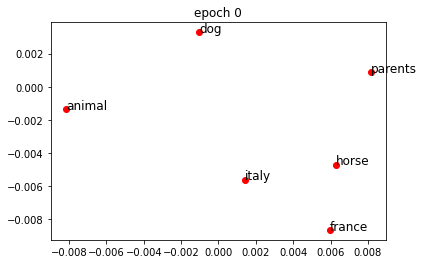

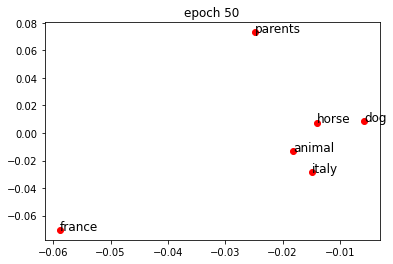

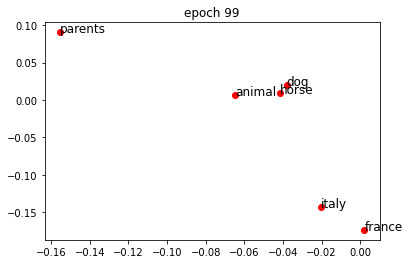

In [ ]:
for epoch in [0, 50, 99]:
  ## load model from checkpoint

  model.load_state_dict(torch.load(os.path.join(PATH_OUTPUT_FOLDER, 'state_{}.pt'.format(epoch))))

  # set the model in evaluation mode
  # (disables dropout, does not update parameters and gradient)
  model.eval()

  # retrieve the trained embeddings
  embeddings = model.embeddings.weight
  
  # pick some words to visualise
  words = ['dog', 'horse', 'animal', 'france', 'italy', 'parents']

  # perform PCA to reduce our 300d embeddings to 2d points that can be plotted
  pca = PCA(n_components=2)
  pca_result = pca.fit_transform(embeddings.detach().t().cpu()) # .t() transpose the embeddings

  indexes = [dataset.word2id[x] for x in words]
  points = [pca_result[i] for i in indexes]
  for i,(x,y) in enumerate(points):
      plt.plot(x, y, 'ro')
      plt.text(x, y, words[i], fontsize=12) # add a point label, shifted wrt to the point
  plt.title('epoch {}'.format(epoch))
  plt.show()
  